In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [26]:
# 🔹 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, auc
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

In [28]:
df = df.drop(columns=['Time'])

In [29]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [31]:
# Standardize 'Amount' column
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Define Features and Target Variable
X = df.drop(columns=['Class'])  # Features (Drop Target)
y = df['Class']  # Target (Fraud/Normal)

In [32]:
# =============================
# 📌 Step 2: Handling Imbalanced Data (Random Under-Sampling)
# =============================

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Convert y_resampled to Pandas Series for proper value_counts()
y_resampled = pd.Series(y_resampled)

# Check new class distribution
print("New class distribution:\n", y_resampled.value_counts())

New class distribution:
 Class
0    492
1    492
Name: count, dtype: int64


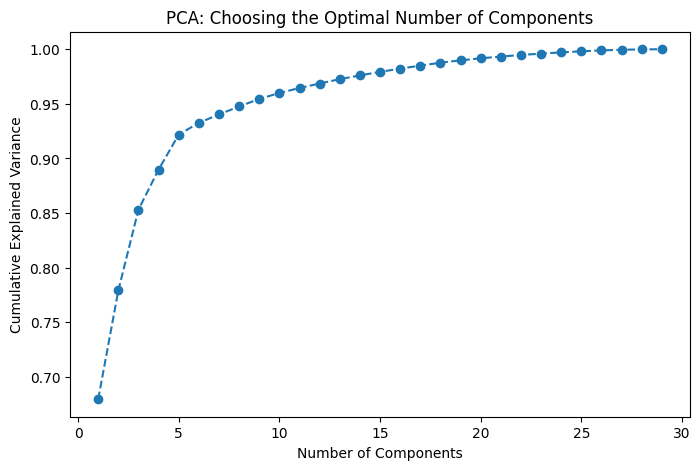

In [33]:
# =============================
# 📌 Step 3: Apply PCA for Feature Reduction
# =============================

# Apply PCA without specifying components to check explained variance
pca = PCA()
X_pca_full = pca.fit_transform(X_resampled)

# Compute cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA: Choosing the Optimal Number of Components")
plt.show()


In [34]:
# Choose optimal number of components that explain 95% variance
optimal_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components: {optimal_components}")

# Apply PCA with selected number of components
pca = PCA(n_components=optimal_components)
X_pca = pca.fit_transform(X_resampled)

Optimal number of components: 9


       TSNE1      TSNE2  Class
0  -2.326966  13.782031      0
1 -14.721174 -10.163828      0
2 -17.132736 -11.050432      0
3   0.465536   5.279950      0
4 -11.994835   4.025188      0
TSNE1    float32
TSNE2    float32
Class      int64
dtype: object


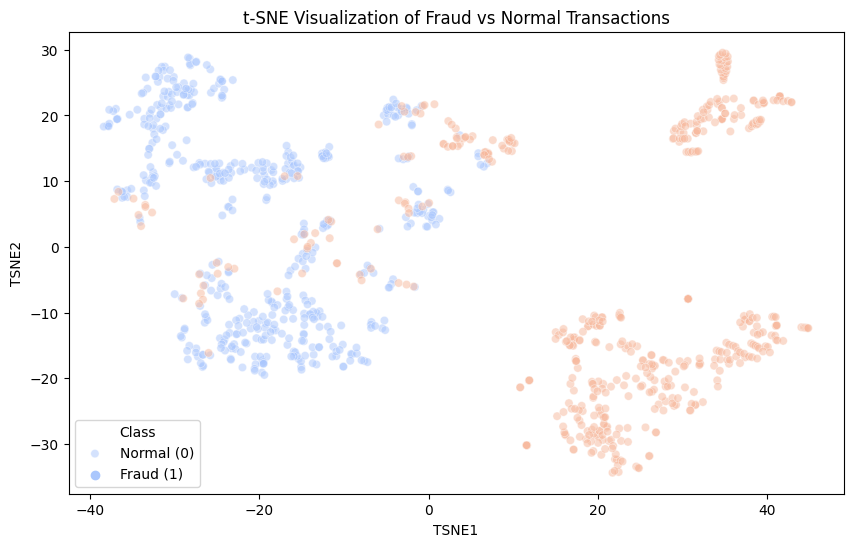

In [38]:
# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# Convert to DataFrame with correct column names
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = y_resampled.values  # Ensure Class column is properly added


print(tsne_df.head())  # Verify column names and structure
print(tsne_df.dtypes)  # Check data types


# Plot t-SNE results correctly
plt.figure(figsize=(10,6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='coolwarm', alpha=0.5)
plt.title("t-SNE Visualization of Fraud vs Normal Transactions")
plt.legend(title="Class", labels=["Normal (0)", "Fraud (1)"])
plt.show()


In [11]:
# =============================
# 📌 Step 4: Split Data into Train and Test
# =============================

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# =============================
# 📌 Step 5: Model Training and Evaluation
# =============================

# ✅ Logistic Regression with Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression()

# Perform Cross-Validation
f1_scores = cross_val_score(lr, X_train, y_train, cv=skf, scoring='f1')
print(f"Average F1-score across folds: {f1_scores.mean():.4f}")

Average F1-score across folds: 0.9406


In [12]:
# Train Logistic Regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Evaluate Logistic Regression Performance
print("Logistic Regression Performance:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Performance:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95        99
           1       0.96      0.95      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



In [13]:
# ✅ Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluate Random Forest Performance
print("Random Forest Performance:\n", classification_report(y_test, y_pred_rf))

Random Forest Performance:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        99
           1       0.95      0.95      0.95        98

    accuracy                           0.95       197
   macro avg       0.95      0.95      0.95       197
weighted avg       0.95      0.95      0.95       197



In [14]:
# =============================
# 📌 Step 6: Hyperparameter Tuning for Random Forest
# =============================

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}


In [15]:
# Train best model
best_rf = grid_search.best_estimator_
y_pred_final = best_rf.predict(X_test)

# Evaluate Final Random Forest Model
print("Final Random Forest Performance:\n", classification_report(y_test, y_pred_final))

Final Random Forest Performance:
               precision    recall  f1-score   support

           0       0.95      0.94      0.94        99
           1       0.94      0.95      0.94        98

    accuracy                           0.94       197
   macro avg       0.94      0.94      0.94       197
weighted avg       0.94      0.94      0.94       197



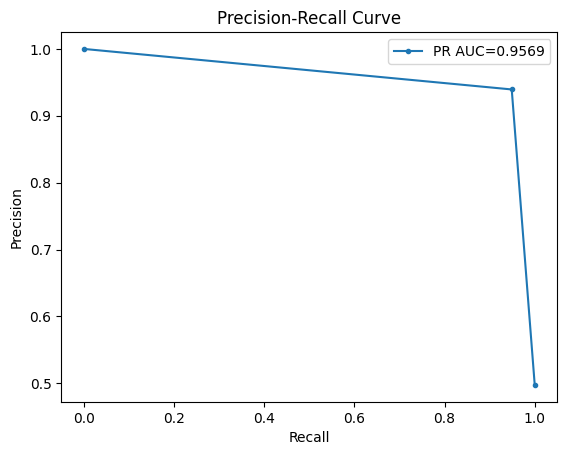

In [16]:
# =============================
# 📌 Step 7: Model Evaluation - Precision-Recall Curve
# =============================

precision, recall, _ = precision_recall_curve(y_test, y_pred_final)
auc_score = auc(recall, precision)

plt.plot(recall, precision, marker='.', label=f'PR AUC={auc_score:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [17]:
# =============================
# 📌 Step 8: Final Observations and Results
# =============================

print("📌 Final Model Performance Summary")
print(f"Logistic Regression F1-Score: {f1_scores.mean():.4f}")
print(f"Random Forest (Tuned) F1-Score: {f1_score(y_test, y_pred_final):.4f}")

print("\n✅ Project Completed: PCA + Undersampling + ML Models Successfully Implemented")

📌 Final Model Performance Summary
Logistic Regression F1-Score: 0.9406
Random Forest (Tuned) F1-Score: 0.9442

✅ Project Completed: PCA + Undersampling + ML Models Successfully Implemented
